<a href="https://colab.research.google.com/github/robimalco/colab/blob/main/House_prices_advanced_regression_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Columns Explaination


- **SalePrice** - the property's sale price in dollars. This is the target variable that you're trying to predict.
- **1stFlrSF**: First Floor square feet
- **2ndFlrSF**: Second floor square feet
- **3SsnPorch**: Three season porch area in square feet
- **Alley**: Type of alley access
- **Bedroom**: Number of bedrooms above basement level
- **BldgType**: Type of dwelling
- **BsmtCond**: General condition of the basement
- **BsmtExposure**: Walkout or garden level basement walls
- **BsmtFinSF1**: Type 1 finished square feet
- **BsmtFinSF2**: Type 2 finished square feet
- **BsmtFinType1**: Quality of basement finished area
- **BsmtFinType2**: Quality of second finished area (if present)
- **BsmtFullBath**: Basement full bathrooms
- **BsmtHalfBath**: Basement half bathrooms
- **BsmtQual**: Height of the basement
- **BsmtUnfSF**: Unfinished square feet of basement area
- **CentralAir**: Central air conditioning
- **Condition1**: Proximity to main road or railroad
- **Condition2**: Proximity to main road or railroad (if a second is present)
- **Electrical**: Electrical system
- **EnclosedPorch**: Enclosed porch area in square feet
- **ExterCond**: Present condition of the material on the exterior
- **Exterior1st**: Exterior covering on house
- **Exterior2nd**: Exterior covering on house (if more than one material)
- **ExterQual**: Exterior material quality
- **Fence**: Fence quality
- **FireplaceQu**: Fireplace quality
- **Fireplaces**: Number of fireplaces
- **Foundation**: Type of foundation
- **FullBath**: Full bathrooms above grade
- **Functional**: Home functionality rating
- **GarageArea**: Size of garage in square feet
- **GarageCars**: Size of garage in car capacity
- **GarageCond**: Garage condition
- **GarageFinish**: Interior finish of the garage
- **GarageQual**: Garage quality
- **GarageType**: Garage location
- **GarageYrBlt**: Year garage was built
- **GrLivArea**: Above grade (ground) living area square feet
- **HalfBath**: Half baths above grade
- **Heating**: Type of heating
- **HeatingQC**: Heating quality and condition
- **HouseStyle**: Style of dwelling
- **Kitchen**: Number of kitchens
- **KitchenQual**: Kitchen quality
- **LandContour**: Flatness of the property
- **LandSlope**: Slope of property
- **LotArea**: Lot size in square feet
- **LotConfig**: Lot configuration
- **LotFrontage**: Linear feet of street connected to property
- **LotShape**: General shape of property
- **LowQualFinSF**: Low quality finished square feet (all floors)
- **MasVnrArea**: Masonry veneer area in square feet
- **MasVnrType**: Masonry veneer type
- **MiscFeature**: Miscellaneous feature not covered in other categories
- **MiscVal**: $Value of miscellaneous feature
- **MoSold**: Month Sold
- **MSSubClass**: The building class
- **MSZoning**: The general zoning classification
- **Neighborhood**: Physical locations within Ames city limits
- **OpenPorchSF**: Open porch area in square feet
- **OverallCond**: Overall condition rating
- **OverallQual**: Overall material and finish quality
- **PavedDrive**: Paved driveway
- **PoolArea**: Pool area in square feet
- **PoolQC**: Pool quality
- **RoofMatl**: Roof material
- **RoofStyle**: Type of roof
- **SaleCondition**: Condition of sale
- **SaleType**: Type of sale
- **ScreenPorch**: Screen porch area in square feet
- **Street**: Type of road access
- **TotalBsmtSF**: Total square feet of basement area
- **TotRmsAbvGrd**: Total rooms above grade (does not include bathrooms)
- **Utilities**: Type of utilities available
- **WoodDeckSF**: Wood deck area in square feet
- **YearBuilt**: Original construction date
- **YearRemodAdd**: Remodel date
- **YrSold**: Year Sold

# Configure and import

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c house-prices-advanced-regression-techniques

In [ ]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip3 install torchvision

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [ ]:
# !nvcc --version
# !python --version
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

# Data Import

In [230]:
original_train_df = pd.read_csv('train.csv')
original_train_df['Source'] = 'train.csv'

original_test_df = pd.read_csv('test.csv')
original_test_df['Source'] = 'test.csv'

total_df = pd.concat([original_train_df, original_test_df], axis=0)

In [231]:
total_df = total_df[["Source", "SalePrice", "MSSubClass", "MSZoning", "LotFrontage", "LotArea", "Street", "YearBuilt", "LotShape", "1stFlrSF", "2ndFlrSF"]]

In [232]:
numerical_columns = []
categorical_columns = []

for column in total_df.columns:
  if total_df.dtypes[column] == np.int64 or total_df.dtypes[column] == np.float64:
    numerical_columns.append(column)
  else:
    categorical_columns.append(column)

categorical_columns.remove('Source')
numerical_columns.remove('SalePrice')

# Data Exploration

In [227]:
list_of_numerics = total_df.select_dtypes(include=['float', 'int']).columns
corrSalePrice = round(total_df[numerical_columns].corrwith(original_train_df['SalePrice']), 3) * 100
types = total_df.dtypes
missing = round((total_df.isnull().sum()/total_df.shape[0]),3)*100
overview = total_df.apply(
    lambda x: [
      round(x.min()), 
      round(x.max()), 
      round(x.mean()), 
      round(x.quantile(0.5))
    ] if x.name in list_of_numerics else x.unique())
outliers = total_df.apply(
    lambda x: sum(
        (x<(x.quantile(0.25)-1.5*(x.quantile(0.75)-x.quantile(0.25)))) | 
        (x>(x.quantile(0.75)+1.5*(x.quantile(0.75)-x.quantile(0.25)))) 
      if x.name in list_of_numerics else ''))
explore_df = pd.DataFrame({
  'Types': types,
  'CorrSalePrice%': corrSalePrice,
  'Missing%': missing,
  'Overview': overview,
  'Outliers': outliers
})
explore_df['Types'] = explore_df['Types'].astype(str)
explore_df.sort_values(by=['Missing%'], ascending=False).transpose()

,SalePrice,1stFlrSF,2ndFlrSF,LotArea,LotFrontage,LotShape,MSSubClass,MSZoning,Source,Street,YearBuilt
Types,float64,int64,int64,int64,float64,category,int64,category,object,category,int64
CorrSalePrice%,NaN,30.3,16.4,17.9,NaN,NaN,-3.1,NaN,NaN,NaN,27.6
Missing%,50,0,0,0,0,0,0,0,0,0,0
Overview,"[34900, 755000, 180921, 163000.0]","[334, 5095, 1160, 1082.0]","[0, 2065, 336, 0.0]","[1300, 215245, 10168, 9453.0]","[69, 69, 69, 69.0]","[3, 0, 1, 2] Categories (4, int64): [3, 0, 1, 2]","[20, 190, 57, 50.0]","[3, 4, 0, 1, 2] Categories (5, int64): [3, 4, ...","[train.csv, test.csv]","[1, 0] Categories (2, int64): [1, 0]","[1872, 2010, 1971, 1973.0]"
Outliers,61,42,8,128,0,0,207,0,0,0,9


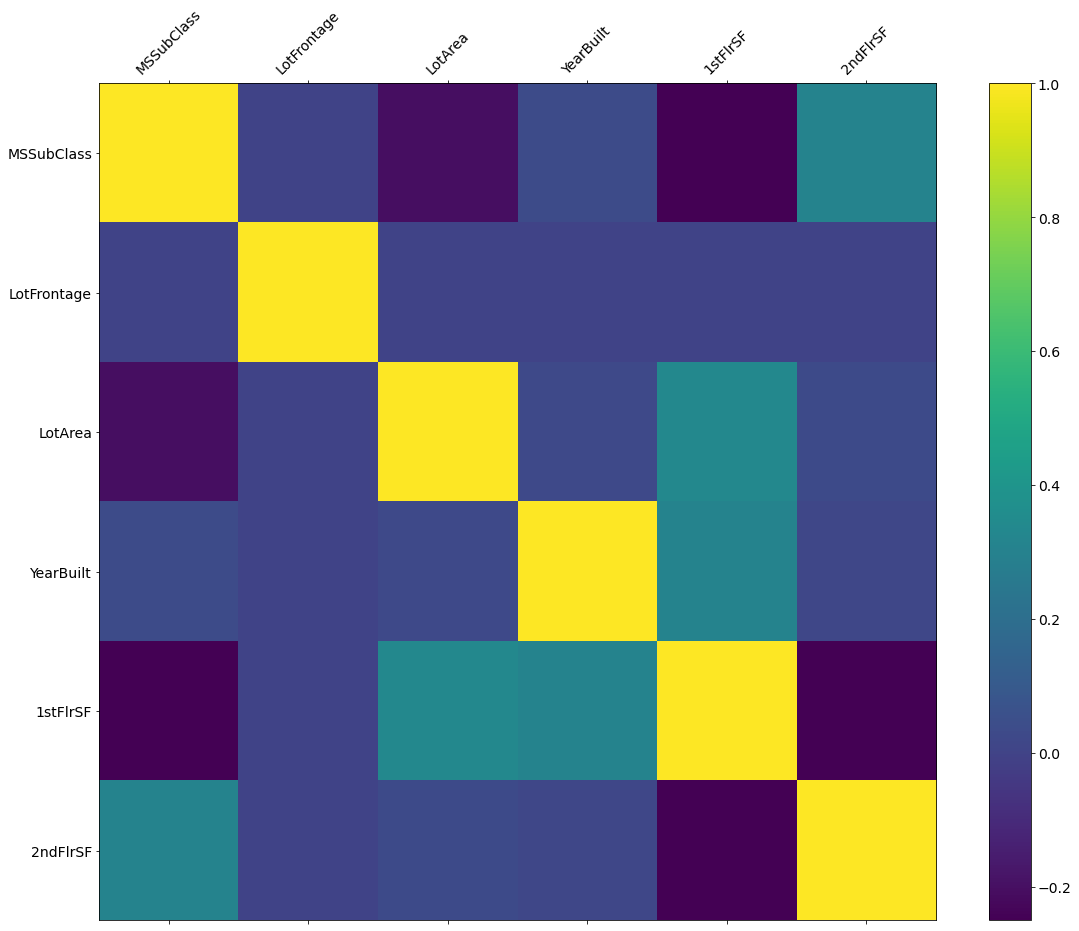

In [228]:
# Plot Correlation Matrix

temp_df = total_df[numerical_columns]
f = plt.figure(figsize=(19, 15))
plt.matshow(temp_df.corr(), fignum=f.number)
plt.xticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14, rotation=45)
plt.yticks(range(temp_df.shape[1]), temp_df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

# Preprocessing

In [233]:
total_df['MSZoning'] = total_df['MSZoning'].fillna(total_df['MSZoning'].mode()[0])
total_df['LotFrontage'] = total_df['LotFrontage'].mean()

# Model Setup

In [234]:
cp_total_df = total_df

In [235]:
pd.options.mode.chained_assignment = None

for column in categorical_columns:
  cp_total_df[column] = LabelEncoder().fit_transform(cp_total_df[column])

for column in categorical_columns:
  cp_total_df[column] = cp_total_df[column].astype('category')

In [236]:
train_df = cp_total_df[cp_total_df['Source'] == 'train.csv'].dropna()
train_output_df = pd.DataFrame(train_df['SalePrice'], columns=['SalePrice'])
train_df.drop('SalePrice', axis=1, inplace=True)
test_df = cp_total_df[cp_total_df['Source'] == 'test.csv']
test_df.drop('SalePrice', axis=1, inplace=True)

In [237]:
def create_categorical_tensor(input_df):
  stack = []
  for column in categorical_columns:
    temp_stack = input_df[column].cat.codes.values
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)

def create_numerical_tensor(input_df):
  stack = []
  for column in numerical_columns:
    temp_stack = input_df[column].astype(np.float64)
    stack.append(temp_stack)
  return torch.tensor(np.stack(stack, 1), dtype=torch.float)


tensor_train_categorical = create_categorical_tensor(train_df[categorical_columns]).float()
tensor_train_numerical = create_numerical_tensor(train_df[numerical_columns]).float()
tensor_output = torch.tensor(train_output_df.values).flatten().float()

tensor_test_categorical = create_categorical_tensor(test_df[categorical_columns]).float()
tensor_test_numerical = create_numerical_tensor(test_df[numerical_columns]).float()

In [238]:
total_records_train = len(tensor_train)
test_records_train = int(total_records_train * 0.2)

tensor_train_categorical_data = tensor_train_categorical[:total_records_train-test_records_train].to(device)
tensor_train_numerical_data = tensor_train_numerical[:total_records_train-test_records_train].to(device)
tensor_train_output = tensor_output[:total_records_train-test_records_train].to(device)

tensor_validation_categorical_data = tensor_train_categorical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_numerical_data = tensor_train_numerical[total_records_train-test_records_train:total_records_train].to(device)
tensor_validation_output = tensor_output[total_records_train-test_records_train:total_records_train].to(device)

In [239]:
categorical_columns_size = [len(train_df[column].astype('category').cat.categories) for column in categorical_columns]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_columns_size]

categorical_embedding_sizes

[(5, 3), (2, 1), (4, 2)]

In [262]:
class Model(nn.Module):
  def __init__(self, embedding_size, num_numerical_cols, layers, p=0.5):
    super().__init__()

    self.all_embeddings = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in embedding_size])
    self.emb_drop = nn.Dropout(p)
    self.bn_cont = nn.BatchNorm1d(num_numerical_cols)

    num_categorical_cols = sum((nf for ni, nf in embedding_size))
    input_size = num_categorical_cols + num_numerical_cols
    
    layerlist = []
    for i in layers:
        layerlist.append(nn.Linear(input_size, i)) 
        layerlist.append(nn.ReLU(inplace=True))
        layerlist.append(nn.BatchNorm1d(i))
        layerlist.append(nn.Dropout(p))
        input_size = i
    layerlist.append(nn.Linear(layers[-1], 1))
        
    self.layers = nn.Sequential(*layerlist)

  def forward(self, x_categorical, x_numerical):

    embeddings = []
    for i,e in enumerate(self.all_embeddings):
        embeddings.append(e(x_categorical[:,i].long()))

    x = torch.cat(embeddings, 1)
    x = self.emb_drop(x)
    
    x_numerical = self.bn_cont(x_numerical)
    x = torch.cat([x, x_numerical], 1)
    x = self.layers(x)

    return x

In [267]:
num_numerical_cols = tensor_train_numerical_data.shape[1]

model = Model(categorical_embedding_sizes, num_numerical_cols, [100, 50], 0.4)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.to(device)

Model(
  (all_embeddings): ModuleList(
    (0): Embedding(5, 3)
    (1): Embedding(2, 1)
    (2): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [268]:
def train_model(fold, epochs, x, y, aggregated_losses):
  for i in range(epochs):
    y_pred = model(x)
    loss = loss_function(y_pred.squeeze(), y)
    optimizer.zero_grad() # sets the gradients of all optimized to zero.
    loss.backward() # compute gradient of loss with respect to all the parameters
    optimizer.step() # iterate and update all parameters based on the current gradient
    if i == epochs - 1:
      print("fold:", fold, "epoch: " + str(i) + "\tloss: " + str(loss.item()))
    aggregated_losses.append(loss)

# TRAIN MODEL

In [271]:
epochs = 5000
aggregated_losses = []

for i in range(epochs):
    i += 1
    y_pred = model(tensor_train_categorical_data, tensor_train_numerical_data)
    single_loss = torch.sqrt(loss_function(y_pred.squeeze(), tensor_train_output))
    aggregated_losses.append(single_loss)
    if i % 500 == 1:
      print("epoch: " + str(i) + "\tloss: " + str(single_loss.item()))

    optimizer.zero_grad()
    single_loss.backward()
    optimizer.step()

print("epoch: " + str(i) + "\tloss: " + str(single_loss.item()))

epoch: 1	loss: 34652.4765625
epoch: 501	loss: 33635.57421875
epoch: 1001	loss: 35049.5078125
epoch: 1501	loss: 35732.3984375
epoch: 2001	loss: 35244.953125
epoch: 2501	loss: 35336.28515625
epoch: 3001	loss: 33675.125
epoch: 3501	loss: 33211.4296875
epoch: 4001	loss: 35406.8359375
epoch: 4501	loss: 33381.40625
epoch: 5000	loss: 34250.5703125


# TEMP CROSS VALIDATION

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)
epochs = 5000
aggregated_losses = []

for fold, (train_index, test_index) in enumerate(kf.split(tensor_train_data, tensor_train_output)):
  x_train_fold = tensor_train_data[train_index].to(device)
  y_train_fold = tensor_train_output[train_index].to(device)
  train_model(fold, epochs, x_train_fold, y_train_fold, aggregated_losses)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(range(0, len(aggregated_losses)), aggregated_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

# VALIDATION

In [ ]:
# Overfitting if: training loss << validation loss
# Underfitting if: training loss >> validation loss
# Just right if training loss ~ validation loss

with torch.no_grad():
    y_val = model(tensor_validation_categorical_data, tensor_validation_numerical_data)
    validation_loss = torch.sqrt(loss_function(y_val.squeeze(), tensor_validation_output))
print("Validation loss: ", str(validation_loss.item()))
print("Train Loss VS Validation loss: ", round(1 - aggregated_losses[len(aggregated_losses) - 1].item() / validation_loss.item(), 2) * 100)

# PREDICTION

In [ ]:
# To remove overfitting
#   Cross-validation: use your initial training data to generate multiple mini train-test splits.
#   Remove features: removing irrelevant input features or aggregate them 
#   Early stopping: stopping the training process before the learner degradates.
#   Regularization: adds a penalty as model complexity increases
#   Ensembling: machine learning methods for combining predictions from multiple separate models. 

In [276]:
# Make predictions
with torch.no_grad():
    tensor_test_categorical_data = tensor_test_categorical.to(device)
    tensor_test_numerical_data = tensor_test_numerical.to(device)
    y_pred = model(tensor_test_categorical_data, tensor_test_numerical_data)

In [ ]:
submission_df = pd.DataFrame(y_pred, columns=['SalePrice']).astype("float")

submission_df = pd.concat([original_test_df, submission_df], axis=1)

submission_df = submission_df[['Id', 'SalePrice']]

submission_df

In [278]:
from google.colab import files
submission_df.to_csv('submission.csv', index=False)
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>